In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)                       # in this gaussian blur we apply the standar deviation of X and Y directions
    # Gaussian Noise is a statistical noise having a probability density function equal to normal distribution, also known as Gaussian Distribution.
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    # For every pixel, the same threshold value is applied. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value. 
    #The function cv.threshold is used to apply the thresholding. 
    #The first argument is the source image, which should be a grayscale image. 
    #The second argument is the threshold value which is used to classify the pixel values. 
    #The third argument is the maximum value which is assigned to pixel values exceeding the threshold.

    thresh = cv2.erode(thresh, None, iterations=2)
    #cv2.erode() method is used to perform erosion on the image. 
    #The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object. 
    #It is normally performed on binary images. It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation. A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).
    thresh = cv2.dilate(thresh, None, iterations=2)
    #This operation is the sister of dilation. It computes a local minimum over the area of given kernel.
   
    
   
    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    cv2.drawContours(image, cnts, -1, (0, 0, 255), 2)
    
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
        cv2_imshow(image)
    
    return new_image


In [ ]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import imutils    
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model


RANDOM_SEED = 123

In [ ]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    i=0
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            # only for plotting single preprocessed brain image image
            if (i==0):
              image = crop_brain_contour(image, plot=True)
              i=i+1
            else:
              image = crop_brain_contour(image, plot=False)

            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            #If you are enlarging the image, you should prefer to use INTER_LINEAR or INTER_CUBIC interpolation. 
            #For shrinking the image, INTER_AREA interpolation.
            #Cubic interpolation is computationally more complex, and hence slower than linear interpolation. 
            #However, the quality of the resulting image will be higher.

            # normalize values
            image = image / 255.
            
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

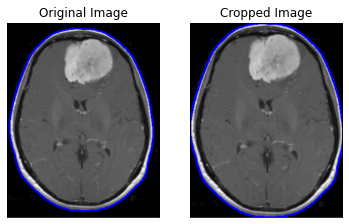

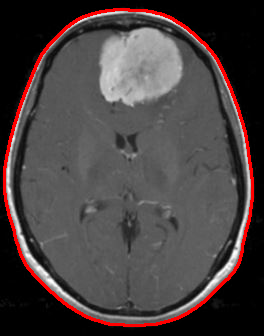

Number of examples is: 3000
X shape is: (3000, 240, 240, 3)
y shape is: (3000, 1)


In [ ]:
augmented_data_path='/content/drive/MyDrive/Colab Notebooks/Data/MAJOR PROJECT/'
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

In [ ]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [ ]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.8)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 2400
number of validation examples = 480
number of test examples = 120


In [ ]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 

    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                           

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
75/75 [==============================] - 219s 3s/step - loss: 0.7496 - accuracy: 0.6717 - val_loss: 0.6264 - val_accuracy: 0.5771
Epoch 2/10
75/75 [==============================] - 214s 3s/step - loss: 0.3782 - accuracy: 0.8392 - val_loss: 0.4699 - val_accuracy: 0.8375
Epoch 3/10
75/75 [==============================] - 213s 3s/step - loss: 0.2972 - accuracy: 0.8775 - val_loss: 0.4159 - val_accuracy: 0.8417
Epoch 4/10
75/75 [==============================] - 213s 3s/step - loss: 0.2289 - accuracy: 0.9104 - val_loss: 0.4297 - val_accuracy: 0.8146
Epoch 5/10
75/75 [==============================] - 214s 3s/step - loss: 0.2048 - accuracy: 0.9254 - val_loss: 0.2881 - val_accuracy: 0.9000
Epoch 6/10
75/75 [==============================] - 214s 3s/step - loss: 0.2091 - accuracy: 0.9154 - val_loss: 0.3524 - val_accuracy: 0.8687
Epoch 7/10
75/75 [==============================] - 214s 3s/step - loss: 0.2063 - accuracy: 0.9108 - val_loss: 0.1998 - val_accuracy: 0.9250
Epoch 8/10
75

In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

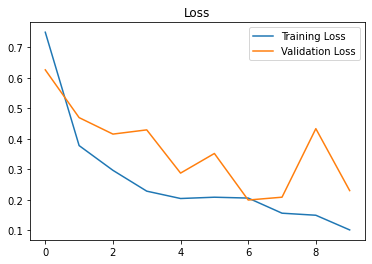

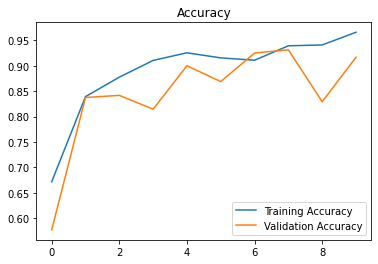

In [ ]:
plot_metrics(history.history)

In [ ]:
model.save("Brain_tumor_detection.h5")

In [ ]:
from keras.models import load_model
tumor_model = load_model('/content/Brain_tumor_detection.h5')
#acc = tumor_model.evaluate(X_test,y_test)


In [ ]:
test_img = cv2.imread('/content/tumory.png')
test_img = cv2.resize(test_img,(240,240))
#test_img.shape
test_img=np.expand_dims(test_img,axis=0)
test_img.shape


(1, 240, 240, 3)

In [ ]:
test_pred = tumor_model.predict(test_img)
test_pred

array([[1.]], dtype=float32)

In [ ]:
if (test_pred[0,0]==1):
  print("Tumor  Found")
else:
  print("Tumor not Found")    

Tumor  Found
